# Supervised CARE Training

Here we use CARE training using noisy images as input and averaged noisy images as target.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../../')
from unet.model import UNet
from pn2v import utils
from pn2v import histNoiseModel
from pn2v import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Download data
Download the data from https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download. Here we show the pipeline for Convallaria dataset. Save the dataset in an appropriate path. For us, the path is the data folder which exists at `../../../`. For Convallaria, the data to be denoised is named ```20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif```.

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data'):
    os.mkdir('../../../data')

zipPath="../../../data/Convallaria_diaphragm.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/BE8raMtHQlgLDF3/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data")


### Load Data
#### Ensure ```filename = 20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif``` and specify the ```dataname```  

In [3]:
path='../../../data/Convallaria_diaphragm/'
fileName='20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif'
dataName='convallaria' # This will be used to name the "care" model

#### Noisy Data (Input to network)

In [4]:
data=imread(path+fileName)
nameModel=dataName+'_care'

#### Ground truth  Data (Target of Network)

In [5]:
dataGT = np.mean(data, axis=0)[np.newaxis,...,np.newaxis]

In [6]:
data=data[...,np.newaxis]
dataGT = np.repeat(dataGT, 100, axis=0)

print("Shape of Raw Noisy Image is ", data.shape, "; Shape of Target Image is ", dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
# Add the target image as a second channel to `data`
print("Shape of `data` is ", data.shape)

Shape of Raw Noisy Image is  (100, 1024, 1024, 1) ; Shape of Target Image is  (100, 1024, 1024, 1)
Shape of `data` is  (100, 1024, 1024, 2)


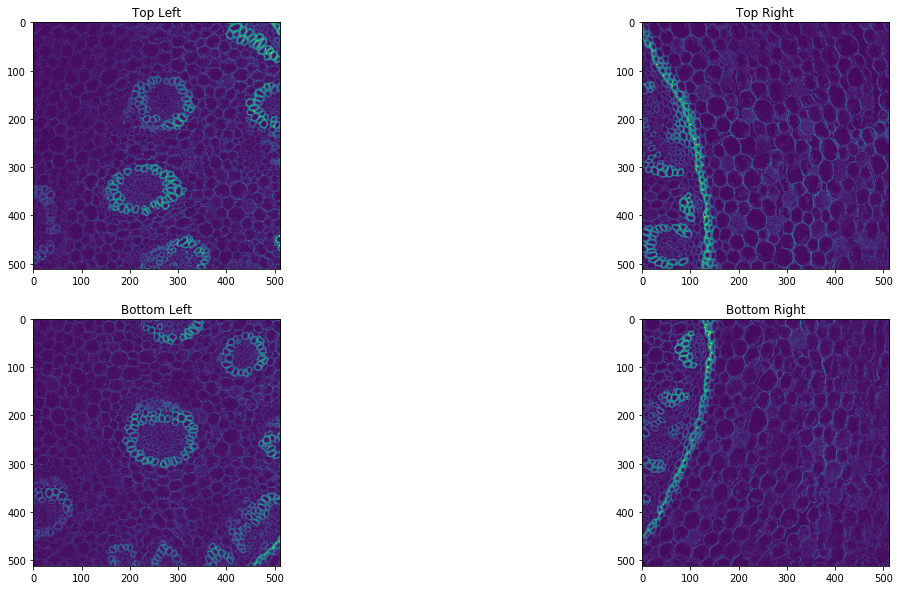

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(2,2,1)
plt.imshow(data[0,:512,:512,0])
plt.title('Top Left')

plt.subplot(2,2,2)
plt.imshow(data[0,:512,512:,0])
plt.title('Top Right')

plt.subplot(2,2,3)
plt.imshow(data[0,512:,:512,0])
plt.title('Bottom Left')

plt.subplot(2,2,4)
plt.imshow(data[0,512:,512:,0])
plt.title('Bottom Right')
plt.show()

# We now crop away the top-left portion of the data since this portion will be used later for testing
data=np.concatenate( (data[:,512:,512:,:], data[:,:512,512:,:], data[:,512:,:512,:])  )

### Create the Network and Train it
This can take a while. Ensure that `supervised` = `True`.

In [8]:
# The N2V network requires only a single output unit per pixel
net = UNet(1, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=nameModel, directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True)

../../../unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
../../../unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)
/home/lalit/Desktop/01_Softwares/anaconda3/envs/ppn2vEnv/lib/python3.7/site-packages/torch/cuda/__init__.py:118: UserWarning: 
    Found GPU1 NVS 310 which is of cuda capability 2.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


Epoch 0 finished      
avg. loss: 0.3841075710952282+-(2SEM)0.14215100616858992      
Epoch 1 finished      
avg. loss: 0.44269797801971433+-(2SEM)0.18134695277804355      
Epoch 2 finished      
avg. loss: 0.1145500280894339+-(2SEM)0.034603352835015026      
Epoch 3 finished      
avg. loss: 0.11915103690698743+-(2SEM)0.06597823132908025      
Epoch 4 finished      
avg. loss: 0.0685845551546663+-(2SEM)0.03402287584617123      
Epoch 5 finished      
avg. loss: 0.05011260798200965+-(2SEM)0.016732257992687623      
Epoch 6 finished      
avg. loss: 0.03783307024277747+-(2SEM)0.013974355202875911      
Epoch 7 finished      
avg. loss: 0.044969237549230455+-(2SEM)0.02036458447201328      
Epoch 8 finished      
avg. loss: 0.03132690787315369+-(2SEM)0.011671194956529636      
Epoch 9 finished      
avg. loss: 0.021629445673897862+-(2SEM)0.004625999585930184      
Epoch 10 finished      
avg. loss: 0.028471421683207154+-(2SEM)0.008641837871436193      
Epoch 11 finished      
avg. loss: 0

Epoch 90 finished      
avg. loss: 0.0157677918439731+-(2SEM)0.004468716432880175      
Epoch 91 finished      
avg. loss: 0.014127009781077504+-(2SEM)0.004110608341227992      
Epoch 92 finished      
avg. loss: 0.01578967529349029+-(2SEM)0.0050184888580079075      
Epoch 93 finished      
avg. loss: 0.017758589400909842+-(2SEM)0.006098377621087491      
Epoch 94 finished      
avg. loss: 0.018564111762680115+-(2SEM)0.006197509981737592      
Epoch 95 finished      
avg. loss: 0.014471056894399226+-(2SEM)0.003987305568115112      
Epoch    95: reducing learning rate of group 0 to 6.2500e-05.
Epoch 96 finished      
avg. loss: 0.01418170586694032+-(2SEM)0.004954755611890502      
Epoch 97 finished      
avg. loss: 0.015695024537853895+-(2SEM)0.003294833767253017      
Epoch 98 finished      
avg. loss: 0.019264660752378406+-(2SEM)0.00675240584494411      
Epoch 99 finished      
avg. loss: 0.01287372587248683+-(2SEM)0.002374381858080614      
Epoch 100 finished      
avg. loss: 0.01719

avg. loss: 0.01748078977689147+-(2SEM)0.0040459756456429595      
Epoch 177 finished      
avg. loss: 0.01994929010979831+-(2SEM)0.006800577868036906      
Epoch 178 finished      
avg. loss: 0.015656277420930564+-(2SEM)0.004151343668082948      
Epoch   178: reducing learning rate of group 0 to 9.7656e-07.
Epoch 179 finished      
avg. loss: 0.014948794478550553+-(2SEM)0.0040109805719061534      
Epoch 180 finished      
avg. loss: 0.014076588186435401+-(2SEM)0.003573176777960402      
Epoch 181 finished      
avg. loss: 0.013339915662072599+-(2SEM)0.002844747315512024      
Epoch 182 finished      
avg. loss: 0.014389284001663328+-(2SEM)0.002761433190798968      
Epoch 183 finished      
avg. loss: 0.015633966540917754+-(2SEM)0.00449751624264016      
Epoch 184 finished      
avg. loss: 0.019168290100060402+-(2SEM)0.006393250470520579      
Epoch 185 finished      
avg. loss: 0.017823658371344208+-(2SEM)0.006292713796793131      
Epoch 186 finished      
avg. loss: 0.0171083351597189

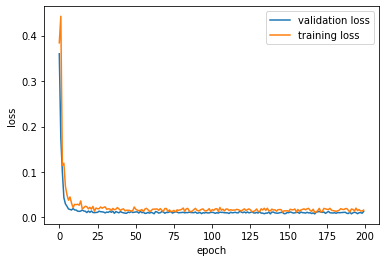

In [10]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()